In [2]:
from dbfread import DBF
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path

# ===== CONFIGURAÇÕES =====
def detectar_pasta_dados():
    possiveis = [
        "./dados",                                     
        "dados",                                     
        "data",                                     
        os.getenv('DBF_DATA_PATH'),                   
        Path.cwd() / "dados",                         
    ]
    
    possiveis = [p for p in possiveis if p is not None]
    
    for pasta in possiveis:
        p = Path(pasta)
        if p.exists() and p.is_dir():
            return str(p)
    
    return "./dados"

PASTA = detectar_pasta_dados()
PADRAO = "*.dbf"
ENC = "latin1"
ALVO_REGS = 500_000

# ===== MAPEAMENTO DAS COLUNAS =====
map_raw = {
    "AP_DTAUT":   "DATA_AUTORIZACAO",
    "AP_DTSOLIC": "DATA_SOLICITACAO",
    "AP_NUIDADE": "IDADE_PACIENTE",
    "AP_SEXO":    "SEXO_PACIENTE",
    "AP_RACACOR": "RACA_PACIENTE",
    "AP_PRIPAL": "PROCEDIMENTO_PRINCIPAL",
    "AP_CIDCAS": "CID_CAUSAS",
    "AP_CIDPRI": "DIAGNOSTICO_PRINCIPAL",
    "AP_CIDSEC": "DIAGNOSTICO_SECUNDARIO",
    "AP_UFNACIO": "NACIONALIDADE_PACIENTE",
    "AP_TPUPS": "TIPO_ESTABELECIMENTO",
    "AP_UFMUN": "LOCALIZACAO_ESTABELECIMENTO"
}

colunas_datas = [
    "DATA_AUTORIZACAO",
    "DATA_SOLICITACAO",
]

colunas_finais = [
    "DATA_PROCESSAMENTO",
    "DATA_SOLICITACAO",
    "IDADE_PACIENTE",
    "SEXO_PACIENTE",
    "RACA_PACIENTE",
    "TEMPO_PROCESSAMENTO_DIAS",
    "CID_CAUSAS",
    "DIAGNOSTICO_PRINCIPAL",
    "DIAGNOSTICO_SECUNDARIO",
    "NACIONALIDADE_PACIENTE",
    "TIPO_ESTABELECIMENTO",
    "LOCALIZACAO_ESTABELECIMENTO"
]

def ler_dbf(path):
    try:
        registros = list(DBF(path, encoding=ENC))
        
        if not registros:
            return pd.DataFrame()
        
        df = pd.DataFrame(registros)
        df.columns = df.columns.astype(str).str.strip()
        
        map_ok = {k: v for k, v in map_raw.items() if k in df.columns}
        if map_ok:
            df = df.rename(columns=map_ok)
        
        return df
        
    except Exception as e:
        print(f"Erro")
        return pd.DataFrame()

# ===== PROCESSAMENTO PRINCIPAL =====
if __name__ == "__main__":
    arquivos = sorted(glob.glob(os.path.join(PASTA, PADRAO)))
    
    dfs = []
    total = 0
    
    for i, f in enumerate(arquivos, 1):
        nome = os.path.basename(f)
        
        df_tmp = ler_dbf(f)
        n = len(df_tmp)
        
        if n == 0:
            continue
        
        print(f"- {n:,} registros")
        dfs.append(df_tmp)
        total += n
        
        if total >= ALVO_REGS:
            break
    
    if not dfs:
        raise RuntimeError(
            "Nenhum dado lido"
        )
    
    df = pd.concat(dfs, ignore_index=True)
    
    
    print("Informações do dataset")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i:2}. {col}")

- 10,628 registros
- 11,256 registros
- 11,318 registros
- 12,636 registros
- 11,653 registros
- 11,495 registros
- 13,580 registros
- 11,941 registros
- 11,493 registros
- 11,856 registros
- 11,811 registros
- 11,908 registros
- 12,046 registros
- 12,260 registros
- 13,700 registros
- 13,449 registros
- 13,801 registros
- 13,403 registros
- 14,609 registros
- 14,255 registros
- 13,160 registros
- 14,107 registros
- 12,056 registros
- 12,920 registros
- 13,444 registros
- 14,707 registros
- 13,824 registros
- 12,556 registros
- 15,439 registros
- 15,633 registros
- 14,766 registros
- 15,431 registros
- 16,943 registros
- 16,370 registros
- 18,203 registros
- 17,229 registros
- 20,588 registros
Informações do dataset
    1. AP_MVM
    2. AP_CONDIC
    3. AP_GESTAO
    4. AP_CODUNI
    5. AP_AUTORIZ
    6. AP_CMP
    7. PROCEDIMENTO_PRINCIPAL
    8. AP_VL_AP
    9. LOCALIZACAO_ESTABELECIMENTO
   10. TIPO_ESTABELECIMENTO
   11. AP_TIPPRE
   12. AP_MN_IND
   13. AP_CNPJCPF
   14. AP_CNPJMN

In [3]:
# ===== LIMPEZA DOS DADOS =====

# Idade
if "IDADE_PACIENTE" in df.columns:
    df["IDADE_PACIENTE"] = pd.to_numeric(df["IDADE_PACIENTE"], errors="coerce").astype("float")
    df = df[(df["IDADE_PACIENTE"] >= 1) & (df["IDADE_PACIENTE"] <= 100)]

# Datas
for c in [c for c in colunas_datas if c in df.columns]:
    df[c] = pd.to_datetime(df[c], format="%Y%m%d", errors="coerce")

# Tempo de processamento
if {"DATA_SOLICITACAO", "DATA_AUTORIZACAO"}.issubset(df.columns):
    delta = (df["DATA_AUTORIZACAO"] - df["DATA_SOLICITACAO"])
    df["TEMPO_PROCESSAMENTO_DIAS"] = delta.dt.total_seconds() / 86400

if "TEMPO_PROCESSAMENTO_DIAS" in df.columns:
    df = df[df["TEMPO_PROCESSAMENTO_DIAS"] < 200]

# Remover NaN no target
antes = len(df)
if "TEMPO_PROCESSAMENTO_DIAS" in df.columns:
    df = df.dropna(subset=["TEMPO_PROCESSAMENTO_DIAS"])

# Normalizar sexo
if "SEXO_PACIENTE" in df.columns:
    df["SEXO_PACIENTE"] = df["SEXO_PACIENTE"].astype("Int8", errors="ignore")

# Janela de datas plausível
INICIO = pd.Timestamp("2024-01-01")
FIM    = pd.Timestamp("2025-10-16")

def dentro_janela(s):
    return s.between(INICIO, FIM)

masc_datas_ok = (
    dentro_janela(df["DATA_SOLICITACAO"]) &
    dentro_janela(df["DATA_AUTORIZACAO"])
)

masc_ordem_ok = df["DATA_AUTORIZACAO"] >= df["DATA_SOLICITACAO"]

df = df[masc_datas_ok & masc_ordem_ok].copy()

print(f"Após limpeza: {len(df):,} (removidos {antes - len(df):,})")

# Selecionar colunas
colunas_existentes = [c for c in colunas_finais if c in df.columns]
df = df[colunas_existentes]

print(f"\nDataset pronto com {len(df):,} linhas.")
print(df.head(3))

Após limpeza: 80,683 (removidos 325,627)

Dataset pronto com 80,683 linhas.
       DATA_SOLICITACAO  IDADE_PACIENTE SEXO_PACIENTE RACA_PACIENTE  \
391504       2024-12-09            78.0             M            01   
398143       2024-01-05            67.0             M            01   
401711       2024-01-17            58.0             F            01   

        TEMPO_PROCESSAMENTO_DIAS CID_CAUSAS DIAGNOSTICO_PRINCIPAL  \
391504                       0.0       0000                  H264   
398143                       0.0       0000                  Z944   
401711                       0.0       H905                  H905   

       DIAGNOSTICO_SECUNDARIO NACIONALIDADE_PACIENTE TIPO_ESTABELECIMENTO  \
391504                   0000                    010                   05   
398143                   0000                    010                   05   
401711                   H905                    010                   04   

       LOCALIZACAO_ESTABELECIMENTO  
391504          

In [4]:
# ===== CRIAÇÃO DE FEATURES =====
df["DATA_SOLICITACAO"] = pd.to_datetime(df["DATA_SOLICITACAO"], errors="coerce")
df["MES_SOLICITACAO"] = df["DATA_SOLICITACAO"].dt.month
df["DIA_SOLICITACAO"] = df["DATA_SOLICITACAO"].dt.day

target = "TEMPO_PROCESSAMENTO_DIAS"
features = [
    "MES_SOLICITACAO",
    "DIA_SOLICITACAO",
    "IDADE_PACIENTE",
    "SEXO_PACIENTE",
    "RACA_PACIENTE",
    "CID_CAUSAS",
    "DIAGNOSTICO_PRINCIPAL",
    "DIAGNOSTICO_SECUNDARIO",
    "LOCALIZACAO_ESTABELECIMENTO",
    "TIPO_ESTABELECIMENTO",
    "NACIONALIDADE_PACIENTE"
]

X = df[features].copy()
y = df[target].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=10 
)

Shape de X: (80683, 11)
Shape de y: (80683,)

SPLIT REALIZADO - MESMO PARA AMBOS OS MODELOS
Tamanho do X_train: 56,478
Tamanho do X_test: 24,205
Tamanho do y_train: 56,478
Tamanho do y_test: 24,205

Top 10 CIDs no X_test:
DIAGNOSTICO_PRINCIPAL
Z940    3225
H360    2944
H353    2449
H259    2243
H251    1501
H264    1435
H900    1360
H250    1231
Z944     962
H905     896
Name: count, dtype: int64


In [5]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

cat_cols = [
    "SEXO_PACIENTE",
    "RACA_PACIENTE",
    "CID_CAUSAS",
    "DIAGNOSTICO_PRINCIPAL",
    "DIAGNOSTICO_SECUNDARIO",
    "TIPO_ESTABELECIMENTO",
    "NACIONALIDADE_PACIENTE"
]


num_cols = [c for c in X_train.columns if c not in cat_cols]
mes_col = ["MES_SOLICITACAO"]
num_cols_sem_mes = [c for c in num_cols if c != "MES_SOLICITACAO"]

mes_pipeline = Pipeline([
    ("pt", PowerTransformer(method='yeo-johnson', standardize=False)),
    ("scaler", StandardScaler())
])

num_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("vt", VarianceThreshold(0.0))
])

preprocess = ColumnTransformer(
    transformers=[
        ("mes", mes_pipeline, mes_col),
        ("num", num_pipeline, num_cols_sem_mes),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop=None), cat_cols)
    ],
    remainder="drop"
)

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import numpy as np

#===========Random-Forest===============
pipe_rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=25,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=10,
        n_jobs=-1,
        verbose=1
    ))
])


pipe_rf.fit(X_train, y_train)

# ===== PREDIÇÕES =====
y_pred_train = pipe_rf.predict(X_train)

y_pred_test = pipe_rf.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ===== MÉTRICAS NO TREINO =====
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# ===== MÉTRICAS NO TESTE =====
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# ===== IMPRIMIR RESULTADOS =====
print("="*70)
print("MÉTRICAS NO CONJUNTO DE TREINO (sem validação cruzada)")
print("="*70)
print(f"MAE:  {mae_train:.4f} dias")
print(f"RMSE: {rmse_train:.4f} dias")
print(f"R²:   {r2_train:.4f}")
print("="*70)

print("\n")

print("="*70)
print("MÉTRICAS NO CONJUNTO DE TESTE")
print("="*70)
print(f"MAE:  {mae_test:.4f} dias")
print(f"RMSE: {rmse_test:.4f} dias")
print(f"R²:   {r2_test:.4f}")
print("="*70)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s


MÉTRICAS NO CONJUNTO DE TREINO (sem validação cruzada)
MAE:  3.4149 dias
RMSE: 8.5401 dias
R²:   0.8279


MÉTRICAS NO CONJUNTO DE TESTE
MAE:  3.9825 dias
RMSE: 9.9596 dias
R²:   0.7651


ANÁLISE DE OVERFITTING (Treino vs Teste)
Gap MAE:  -0.5675 dias (-14.25%)
Gap RMSE: -1.4195 dias (-14.25%)
Gap R²:   0.0627 (8.20%)


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished


In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import joblib

# ============================================================================
# Treinamento Modelo MLP
# ============================================================================
mlp_model = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-3,
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", mlp_model)
])


pipe.fit(X_train, y_train)

y_train_pred_mlp = pipe.predict(X_train)
y_test_pred_mlp = pipe.predict(X_test)

r2_train_mlp = r2_score(y_train, y_train_pred_mlp)
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
rmse_train_mlp = np.sqrt(mean_squared_error(y_train, y_train_pred_mlp))

r2_test_mlp = r2_score(y_test, y_test_pred_mlp)
mae_test_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
rmse_test_mlp = np.sqrt(mean_squared_error(y_test, y_test_pred_mlp))

print("Métricas de Treinamento")
print(r2_train_mlp)
print(mae_train_mlp)
print(rmse_train_mlp)
print("Métricas de Teste")
print(r2_test_mlp)
print(mae_test_mlp)
print(rmse_test_mlp)


Iniciando treinamento...

Realizando predições...
Métricas de Treinamento
0.7773353143092997
4.3017193869748285
9.71350757923161
Métricas de Teste
0.7214021002237025
4.800779320077706
10.847321446465134


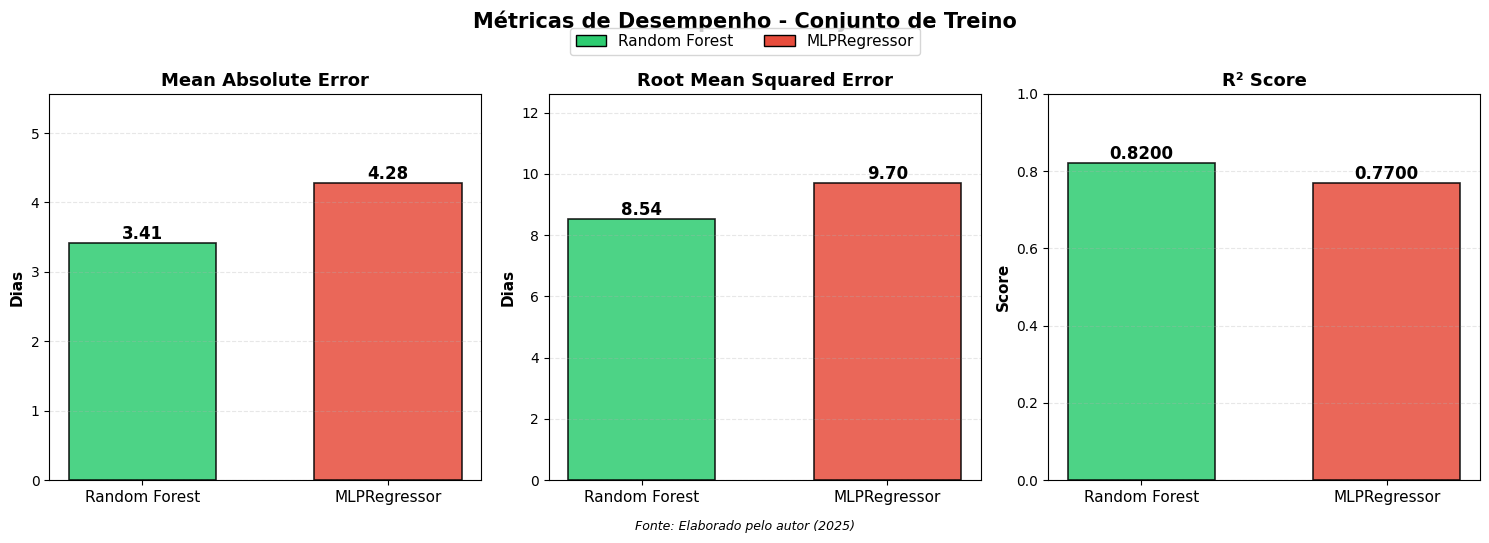

✅ Gráfico 1 salvo: comparacao_treino.png


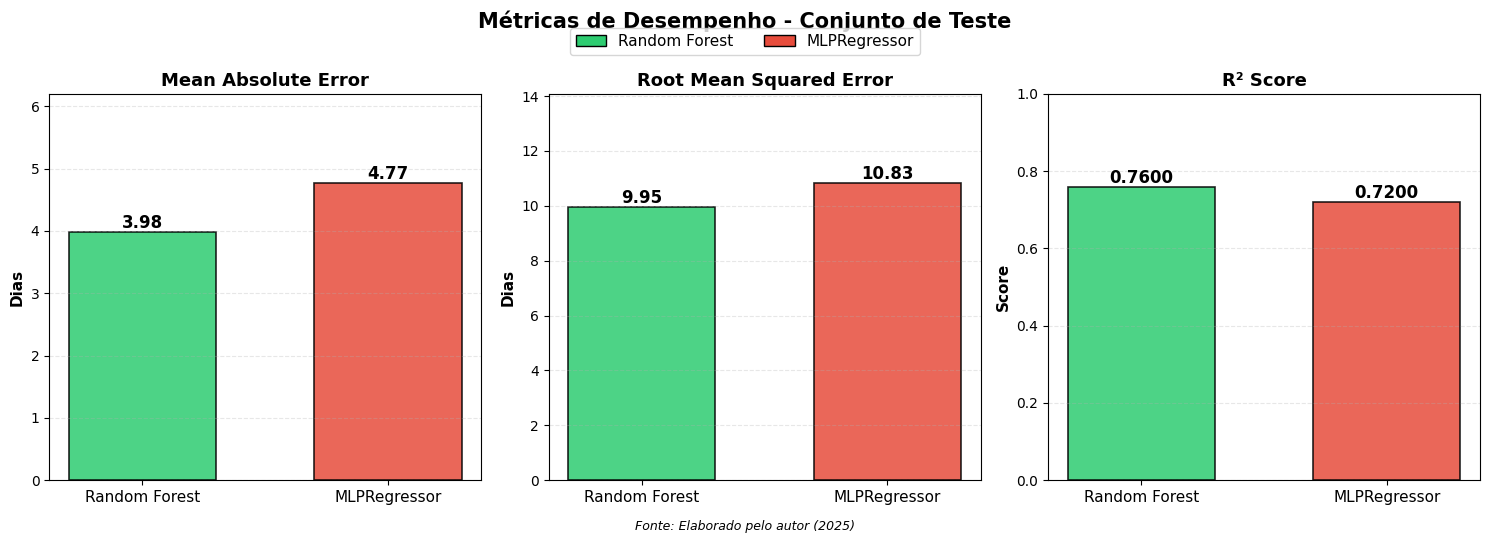

✅ Gráfico 2 salvo: comparacao_teste.png

📊 Dois gráficos criados:
   1. comparacao_treino.png
   2. comparacao_teste.png


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Dados dos modelos
modelos = ['Random Forest', 'MLPRegressor']

# Métricas de TREINO
mae_treino = [3.41, 4.28]
rmse_treino = [8.54, 9.70]
r2_treino = [0.82, 0.77]

# Métricas de TESTE
mae_teste = [3.98, 4.77]
rmse_teste = [9.95, 10.83]
r2_teste = [0.76, 0.72]

cores = ['#2ECC71', '#E74C3C'] 

# ============================================
# GRÁFICO 1: TREINO
# ============================================
fig1, axes1 = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(len(modelos))

ax1 = axes1[0]
bars1 = ax1.bar(x, mae_treino, color=cores, alpha=0.85, width=0.6, edgecolor='black', linewidth=1.2)
for bar, val in zip(bars1, mae_treino):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(modelos, fontsize=11)
ax1.set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
ax1.set_ylabel('Dias', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(mae_treino) * 1.3)

ax2 = axes1[1]
bars2 = ax2.bar(x, rmse_treino, color=cores, alpha=0.85, width=0.6, edgecolor='black', linewidth=1.2)
for bar, val in zip(bars2, rmse_treino):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(modelos, fontsize=11)
ax2.set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
ax2.set_ylabel('Dias', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(rmse_treino) * 1.3)

ax3 = axes1[2]
bars3 = ax3.bar(x, r2_treino, color=cores, alpha=0.85, width=0.6, edgecolor='black', linewidth=1.2)
for bar, val in zip(bars3, r2_treino):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(modelos, fontsize=11)
ax3.set_title('R² Score', fontsize=13, fontweight='bold')
ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_ylim(0, 1.0)

# Adicionar legenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=cores[0], edgecolor='black', label='Random Forest'),
                   Patch(facecolor=cores[1], edgecolor='black', label='MLPRegressor')]
fig1.legend(handles=legend_elements, loc='upper center', ncol=2,
           frameon=True, fontsize=11, bbox_to_anchor=(0.5, 1.00))

plt.suptitle('Métricas de Desempenho - Conjunto de Treino',
             fontsize=15, fontweight='bold', y=1.02)

fig1.text(0.5, -0.02, 'Fonte: Elaborado pelo autor (2025)',
         ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

# ============================================
# GRÁFICO 2: TESTE
# ============================================
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

# MAE Teste
ax4 = axes2[0]
bars4 = ax4.bar(x, mae_teste, color=cores, alpha=0.85, width=0.6, edgecolor='black', linewidth=1.2)
for bar, val in zip(bars4, mae_teste):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(modelos, fontsize=11)
ax4.set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
ax4.set_ylabel('Dias', fontsize=11, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_ylim(0, max(mae_teste) * 1.3)

# RMSE Teste
ax5 = axes2[1]
bars5 = ax5.bar(x, rmse_teste, color=cores, alpha=0.85, width=0.6, edgecolor='black', linewidth=1.2)
for bar, val in zip(bars5, rmse_teste):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(modelos, fontsize=11)
ax5.set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
ax5.set_ylabel('Dias', fontsize=11, fontweight='bold')
ax5.grid(axis='y', alpha=0.3, linestyle='--')
ax5.set_ylim(0, max(rmse_teste) * 1.3)

# R² Teste
ax6 = axes2[2]
bars6 = ax6.bar(x, r2_teste, color=cores, alpha=0.85, width=0.6, edgecolor='black', linewidth=1.2)
for bar, val in zip(bars6, r2_teste):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(modelos, fontsize=11)
ax6.set_title('R² Score', fontsize=13, fontweight='bold')
ax6.set_ylabel('Score', fontsize=11, fontweight='bold')
ax6.grid(axis='y', alpha=0.3, linestyle='--')
ax6.set_ylim(0, 1.0)

# Adicionar legenda
fig2.legend(handles=legend_elements, loc='upper center', ncol=2,
           frameon=True, fontsize=11, bbox_to_anchor=(0.5, 1.00))

plt.suptitle('Métricas de Desempenho - Conjunto de Teste',
             fontsize=15, fontweight='bold', y=1.02)

fig2.text(0.5, -0.02, 'Fonte: Elaborado pelo autor (2025)',
         ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

print("   1. comparacao_treino.png")
print("   2. comparacao_teste.png")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Criar figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ===== Random Forest =====
axes[0].scatter(y_test, y_pred_test, alpha=0.5, color='green', edgecolors='darkgreen', s=50)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Predição Perfeita')
axes[0].set_xlabel('Valores Reais (dias)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valores Preditos (dias)', fontsize=12, fontweight='bold')
axes[0].set_title('Random Forest Regressor', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Adicionar R² no gráfico
r2_rf = 0.76  # Substituir pelo valor calculado
axes[0].text(0.05, 0.95, f'R² = {r2_rf:.4f}',
             transform=axes[0].transAxes,
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ===== MLPRegressor =====
axes[1].scatter(y_test, y_test_pred_mlp, alpha=0.5, color='orange', edgecolors='darkred', s=50)
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Predição Perfeita')
axes[1].set_xlabel('Valores Reais (dias)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valores Preditos (dias)', fontsize=12, fontweight='bold')
axes[1].set_title('MLPRegressor', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Adicionar R² no gráfico
r2_mlp = 0.72  # Substituir pelo valor calculado
axes[1].text(0.05, 0.95, f'R² = {r2_mlp:.4f}',
             transform=axes[1].transAxes,
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Título geral
fig.suptitle('Comparação: Valores Preditos vs. Valores Reais - Conjunto de Teste',
             fontsize=16, fontweight='bold', y=1.02)

# Fonte no rodapé
fig.text(0.5, -0.02, 'Fonte: Elaborado pelo autor (2025)',
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('dispersao_predito_vs_real.png', dpi=300, bbox_inches='tight')
plt.show()

Calculando Permutation Importance - Random Forest...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


Calculando Permutation Importance - MLP...


C:\Users\ariadne.jorge\AppData\Local\Temp\ipykernel_41272\2100161318.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


✅ Salvo: figuras/importance_rf_boxplot.png


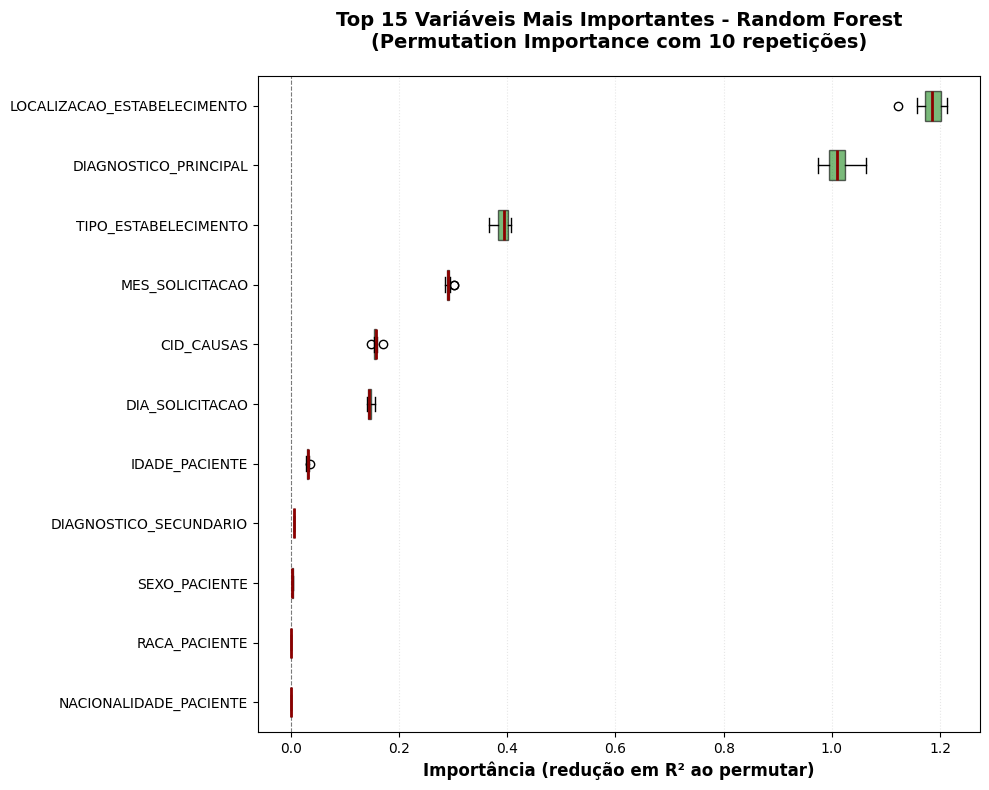

C:\Users\ariadne.jorge\AppData\Local\Temp\ipykernel_41272\2100161318.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


✅ Salvo: figuras/importance_mlp_boxplot.png


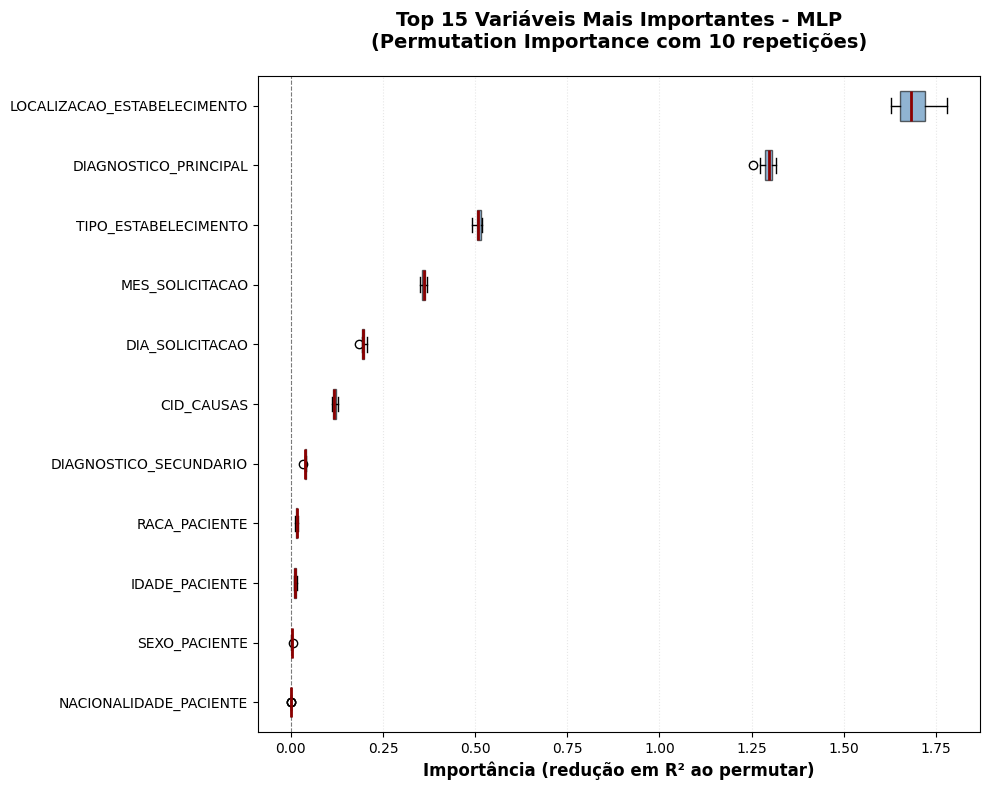


📊 TOP 10 - RANDOM FOREST:
                    feature  importance_mean  importance_std
LOCALIZACAO_ESTABELECIMENTO         1.181941        0.025895
      DIAGNOSTICO_PRINCIPAL         1.010383        0.025298
       TIPO_ESTABELECIMENTO         0.391236        0.012671
            MES_SOLICITACAO         0.291639        0.005799
                 CID_CAUSAS         0.157370        0.005350
            DIA_SOLICITACAO         0.146330        0.004473
             IDADE_PACIENTE         0.031502        0.001978
     DIAGNOSTICO_SECUNDARIO         0.006068        0.000390
              SEXO_PACIENTE         0.003100        0.000808
              RACA_PACIENTE         0.000480        0.000142

📊 TOP 10 - MLP:
                    feature  importance_mean  importance_std
LOCALIZACAO_ESTABELECIMENTO         1.690440        0.047017
      DIAGNOSTICO_PRINCIPAL         1.293448        0.017912
       TIPO_ESTABELECIMENTO         0.507846        0.009351
            MES_SOLICITACAO         0.360

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
import os

perm_importance_rf = permutation_importance(
    pipe_rf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=10,
    n_jobs=-1,
    scoring='r2'
)

perm_importance_mlp = permutation_importance(
    pipe,
    X_test,
    y_test,
    n_repeats=10,
    random_state=10,
    n_jobs=-1,
    scoring='r2'
)


feature_names = X_train.columns

importance_rf = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance_rf.importances_mean,
    'importance_std': perm_importance_rf.importances_std
}).sort_values('importance_mean', ascending=False)

importance_mlp = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance_mlp.importances_mean,
    'importance_std': perm_importance_mlp.importances_std
}).sort_values('importance_mean', ascending=False)


def plot_permutation_importance(perm_importance, feature_names, title, filename, color='steelblue'):
    sorted_idx = perm_importance.importances_mean.argsort()[-15:]  # Top 15
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Boxplot horizontal
    ax.boxplot(
        perm_importance.importances[sorted_idx].T,
        vert=False,
        labels=np.array(feature_names)[sorted_idx],
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=0.6),
        medianprops=dict(color='darkred', linewidth=2),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1)
    )
    
    ax.set_xlabel('Importância (redução em R² ao permutar)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.8)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Salvo: {filename}")
    plt.show()

# Criar diretórios
os.makedirs('figuras', exist_ok=True)
os.makedirs('resultados', exist_ok=True)

# Plotar Random Forest
plot_permutation_importance(
    perm_importance_rf,
    feature_names,
    'Top 15 Variáveis Mais Importantes - Random Forest\n(Permutation Importance com 10 repetições)',
    'figuras/importance_rf_boxplot.png',
    color='forestgreen'
)

# Plotar MLP
plot_permutation_importance(
    perm_importance_mlp,
    feature_names,
    'Top 15 Variáveis Mais Importantes - MLP\n(Permutation Importance com 10 repetições)',
    'figuras/importance_mlp_boxplot.png',
    color='steelblue'
)

# ==========================================
# 4. SALVAR RESULTADOS
# ==========================================
importance_rf.to_csv('resultados/importance_rf.csv', index=False)
importance_mlp.to_csv('resultados/importance_mlp.csv', index=False)

print(importance_rf.head(10).to_string(index=False))

print(importance_mlp.head(10).to_string(index=False))